# ElasticNet

### 1. Introdução ao ElasticNet

#### 1.1 Teoria

Em Machine Learning, a regressão linear é um dos modelos mais simples de previsão de dados. Porém, ela pode sofrer com o Underfit e Overfit. O que acontece é que a regressão linear faz previsões calculando um polinômio para tentar representar o resultado, porém, para representar com grande acurácia os dados de treino, é necessário um polinômio de grau alto, que pode gerar resultados melhores para os dados de treino, mas piores para os demais, ou seja overfit (super ajustado). Veja na imagem abaixo:
<div align="center">
    <img src="https://analystprep.com/study-notes/wp-content/uploads/2021/03/Img_13.jpg" alt="Fern vs Ehre" width="800">
</div>

Pensando nisso, foram desenvolvidos modelos de regularização do grau desses polinômios para evitar o Overfit, como é o caso do L1 (LASSO) e L2 (Ridge). Ambos os métodos tentam diminuir o efeito de Overfitting da regressão. Primeiramento relembremos o cálculo do MSE:

$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

Suponha que o valor a ser predito seja um polinômio tal que:
$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...$$

Substituindo:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - (\theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...))^2
$$

Chamemos o polinômio de f, para simplificar
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2
$$

Para diminuir o grau do polinômio, a regularização acrescenta um demérito para graus maiores. Veja como é feito em L2:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha\sum_{i=1}^{n}(\theta_i)^2
$$
Ou seja, quanto maior n, maior o somatório dos quadrados de theta, sendo vantajoso um modelo que tenha menor grau e boa precisão. Alpha é uma constante que pode ser escolhida para ditar o peso do demérito.

Agora, vejamos como é feito em L1:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha\sum_{i=1}^{n}|\theta_i|
$$
Ele também adiciona um demérito para o aumento de grau, mas agora usando o módulo de theta com a constante alpha.

Porém, podemos usar L1 e L2 juntos e isso é o Elastic Net:
$$
MSE = \frac{1}{2n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha(l_1ratio)\sum_{i=1}^{n}|\theta_i| + 0.5\alpha(1-l_1ratio)\sum_{i=1}^{n}(\theta_i)^2
$$

#### 1.2 ElasticNet no sklearn

No sklearn, ElasticNet está em linear_model. Ele pode receber como parâmetros:

→ alpha - controla o peso da regularização. std=1

→ l1_ratio - controla a proporção entre L1 e L2. std=0.5

→ max_iter - número máximo de iterações do algoritmo de otimização para encontrar a melhor solução. std=1000

→ tol - tolerância da melhoria para até onde o modelo tenta otimizar. std=1e-4

→ selection - cyclic, atualiza as features sequencialmente, random, atualiza em qualquer ordem. std=cyclic

→ fit_intercept - adiciona uma constante ao polinômio. std=true

→ positive - faz todos os thetas serem positivos. std=False

### 2. Treino de Modelo

Primeiro importamos as bibliotecas e o dataframe

In [34]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from optuna import create_study
from optuna.pruners import HyperbandPruner
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv('../dataset_processing/xtb_dataset.csv')
df

,Dipole,E_HOMO,E_LUMO,gap_HOMO-LUMO,ZPE,H,U,U0,G,Delta
0,0.727,-10.6203,-2.7950,-7.8253,0.154214,-27.917739,-27.918683,-28.080950,-27.959630,-12.397982
1,1.905,-10.4336,-2.2949,-8.1387,0.199866,-28.104404,-28.105348,-28.313524,-28.146070,-12.165407
2,4.475,-10.5746,-6.9494,-3.6252,0.120064,-27.272560,-27.273504,-27.400818,-27.312535,-13.078113
3,2.100,-9.8173,-5.5314,-4.2859,0.177677,-27.068399,-27.069343,-27.254803,-27.108720,-13.224129
4,0.872,-9.9722,-6.6172,-3.3550,0.133244,-24.148876,-24.149821,-24.292155,-24.192788,-16.186776
...,...,...,...,...,...,...,...,...,...,...
129152,4.710,-11.3840,-7.8335,-3.5505,0.121817,-26.808903,-26.809847,-26.939965,-26.851229,-13.538966
129153,4.996,-10.8793,-7.1097,-3.7696,0.141742,-28.278349,-28.279293,-28.428099,-28.317523,-12.050832
129154,3.973,-10.9497,-7.7346,-3.2151,0.124894,-24.819326,-24.820270,-24.952019,-24.858199,-15.526912
129155,0.918,-10.2869,-1.8611,-8.4258,0.195977,-30.002576,-30.003520,-30.208931,-30.047056,-10.270000


In [ ]:
X = df.drop("Delta", axis=1)
y = df["Delta"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=27)

Agora, instanciamos o modelo com todos seus parâmetros e tratamentos a serem usados pelo optuna.

In [ ]:
def inst_elasticnet(trial):
    parametros = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e3, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'positive': trial.suggest_categorical("positive", [False, True]),
        'max_iter': trial.suggest_int('max_iter', 1000, 40000),
        'tol': trial.suggest_float('tol', 1e-8, 1e-3, log=True),
        'selection': trial.suggest_categorical('selection', ['cyclic', 'random'])
    }

    normalizar = trial.suggest_categorical('normalizar', [None, 'stds' 'pca', 'limiar', 'rfe'])
    if normalizar == 'stds':
        modelo = make_pipeline(StandardScaler(), ElasticNet(**parametros))
    elif normalizar == "pca":
        # Definindo o número de componentes a serem mantidas
        components = trial.suggest_int("pca_components", 2, 50)
        modelo = make_pipeline(
            StandardScaler(),
            PCA(components),
            ElasticNet(**parametros))
    elif normalizar == "limiar":
        # Definindo o Limiar a ser utilizado
        threshold = trial.suggest_float("variance_threshold", 0, 0.1)
        modelo = make_pipeline(
            StandardScaler(),
            VarianceThreshold(threshold),
            ElasticNet(**parametros)
        )
    elif normalizar == "rfe": 
        # Criando o modelo para parametro do RFE
        estimator = RandomForestRegressor()
        # Definindo o número de atributos a serem mantidos
        n_features_to_select = trial.suggest_int("rfe_features", 2, 50)
        modelo = make_pipeline(
            StandardScaler(),
            RFE(estimator=estimator, n_features_to_select=n_features_to_select),
            ElasticNet(**parametros)
        )
    else:
        modelo = ElasticNet(**parametros)

    return modelo

Criar função objetivo de cross validation

In [ ]:
def funcao_objetivo(trial, X, y, num_folds, instanciador):
    modelo = instanciador(trial)

    metricas = -cross_val_score(
        modelo,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=num_folds,
        n_jobs=-1
    )
    return metricas.mean()


Implementar o optuna

In [ ]:
def rodar_optuna(nome_estudo, X, y, instanciador, num_folds=5, n_trials=1000):
    study = create_study(
        direction='minimize',
        study_name=nome_estudo,
        storage=f'sqlite:///{nome_estudo}.db',
        load_if_exists=True,
        pruner=HyperbandPruner(min_resource=1, max_resource=100, reduction_factor=3)
    )

    def objetivo_parcial(trial):
        return funcao_objetivo(trial, X, y, num_folds, instanciador)

    study.optimize(objetivo_parcial, n_trials=n_trials)
    return study


In [ ]:
study_en = rodar_optuna('elasticnet_xtb', X_train, y_train, inst_elasticnet)

### 3. Resultados

Portanto, utilizando-se do Optuna Dashboard conseguimos:

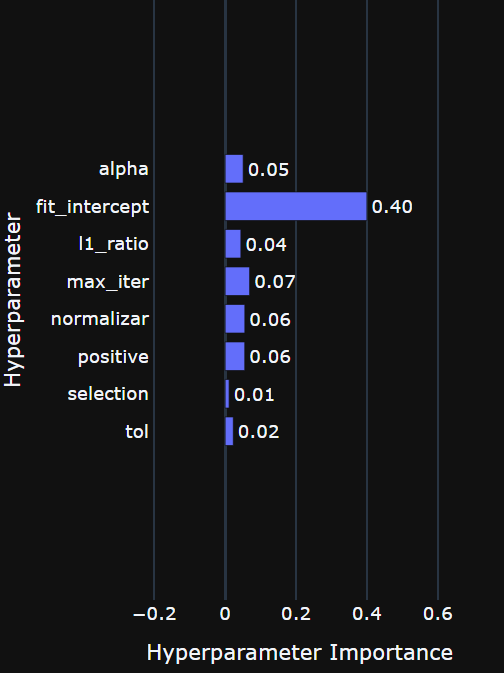

In [36]:
from IPython.display import Image
Image(filename='../images/en_parameters.png', height=200, width=700)

Percebe-se que o trial 810 foi o melhor e analisando-se os resultados até ele, o RMSE não deve aumentar significativamente mais.

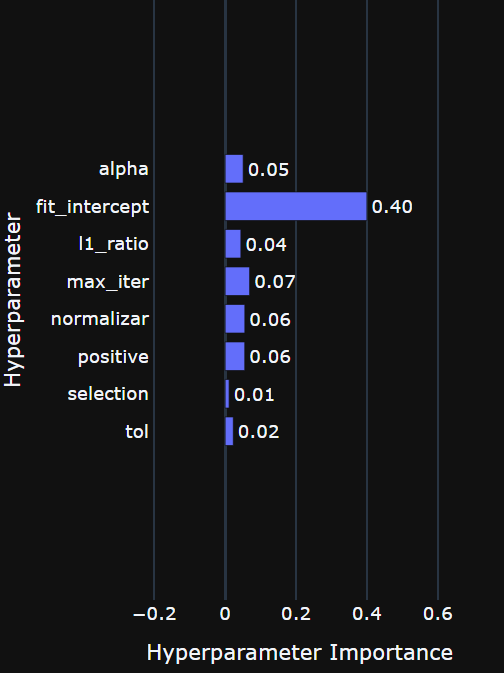

In [37]:
Image(filename='../images/en_parameters.png', width=300)

Vê-se que o fit_intercept foi o parâmetro significativamente mais importante. Selection tem importância tendendo a zero, como era de se esperar.

Para o trial de melhor resultado, os parâmetros eram:

Trial 810 finished with value: 0.00014746162905534939 and parameters: {'alpha': 0.00006820706258709369, 'l1_ratio': 0.17332460629146462, 'fit_intercept': True, 'positive': False, 'max_iter': 33778, 'tol': 8.423671561653807e-7, 'selection': 'random', 'normalizar': 'rfe', 'rfe_features': 31}.

O resultado é muito promissor,com primeiro algarismo na quarta casa após a vírgula sendo 1. O RMSE é muito baixo, sendo possível ótima correção dos cálculos do xtb usando-se do ElasticNet.

### 4. Referências
DATACAMP. Tutorial: Regressão Lasso e Ridge no Python. 2025. Disponível em: https://www.datacamp.com/pt/tutorial/tutorial-lasso-ridge-regression. Acesso em: 27 set. 2025.

PEDREGOSA, F. et al. sklearn.linear_model.ElasticNet. Scikit-learn, 2025. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html. Acesso em: 27 set. 2025.

THE PANDAS DEVELOPMENT TEAM. pandas.DataFrame.drop. Pandas, 2025. Disponível em: https://pandas.pydata-org.translate.goog/docs/reference/api/pandas.DataFrame.drop.html?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc. Acesso em: 27 set. 2025.

ZINI, Fernando. Regressão Linear: Teoria e Prática. YouTube, 10 set. 2023. Disponível em: https://www.youtube.com/watch?v=VqKq78PVO9g. Acesso em: 27 set. 2025.

PEDREGOSA, F. et al. 1.1. Linear Models. Scikit-learn, 2025. Disponível em: https://scikit-learn.org/stable/modules/linear_model.html. Acesso em: 27 set. 2025.

DeepSeek. Disponível em: https://chat.deepseek.com/share/j7z37nakhld1e4jftp. Acesso em: 27 set. 2025.

KAGGLE. Student Academic Performance Trends Dataset. 2024. Disponível em: https://www.kaggle.com/datasets/emanfatima2025/student-academic-performance-trends Acesso em: 27 set. 2025.

Modelos 3, 2025. Silveira Matheus. Acesso em: 25 out. 2025.

Modelos 7, 2025. Neto Aniel et al. Acesso em: 25 set. 2025.

Modelos 6, 2025. Mendes Mateus et al. Acesso em: 25 out. 2025.